In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd

In [2]:
# For aesthetics/plotting.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [3]:
from preprocess import AnomalyDetectionDataset, device_change, load_anomaly_dataset_csv
from model import AutoencoderAnomalyDetection, evaluate_model
from torch import nn

In [4]:
# Working directory.
data_dir = '/users/eserebri/data/eserebri/PHYS2550FinalProject/anomaly detection'

In [5]:
# Switch to GPU if there is one.
device = device_change()

Using cuda device


### Load Data as $\texttt{tf.utils.DataLoader}$

In [6]:
file_names = {
    'background': 'X_test', 
    'first_box': 'X_test_first',
    'second_box': 'X_test_second',
    'third_box': 'X_test_third'
}
# file_name = {'background': 'X_test_small'}
batch_size = 350

In [7]:
data = load_anomaly_dataset_csv(
    file_name=file_names,
    file_directory=f'{data_dir}', 
    batch_size=batch_size, 
    three_channels=True
)

In [8]:
data

{'background': <torch.utils.data.dataloader.DataLoader at 0x7fe5d6e702d0>,
 'first_box': <torch.utils.data.dataloader.DataLoader at 0x7fe4b8630f10>,
 'second_box': <torch.utils.data.dataloader.DataLoader at 0x7fe4b8c51f50>,
 'third_box': <torch.utils.data.dataloader.DataLoader at 0x7fe008b34fd0>}

### Model Evaluation

In [9]:
# Load model parameters.
PATH = f'{data_dir}/model_par/autoencoder_state_dict.pth'
model = AutoencoderAnomalyDetection().to(device)
model.load_state_dict(torch.load(PATH))
# model.state_dict() # Print parameters.
loss_function = nn.MSELoss()

In [10]:
# Make predictions.
loss = {}
for key, value in data.items():
    loss_current = evaluate_model(
        dataloader_test=value,
        model=model,
        loss_func=loss_function,
        batch_size=batch_size
    )
    loss.update({key: loss_current})

### Plot Results

In [11]:
threshold = 3 * loss['background'].std() + loss['background'].mean()
threshold

12.0670711710128

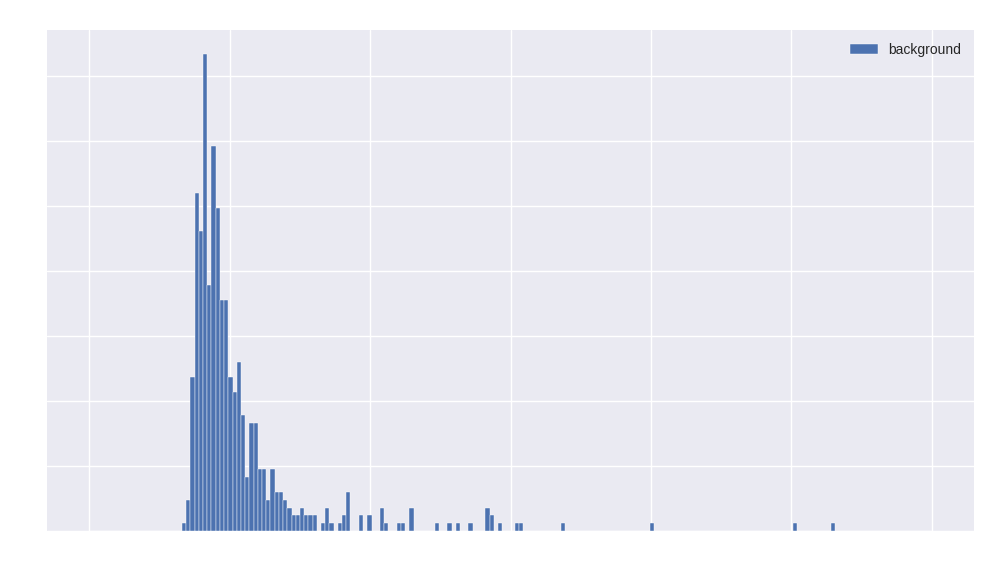

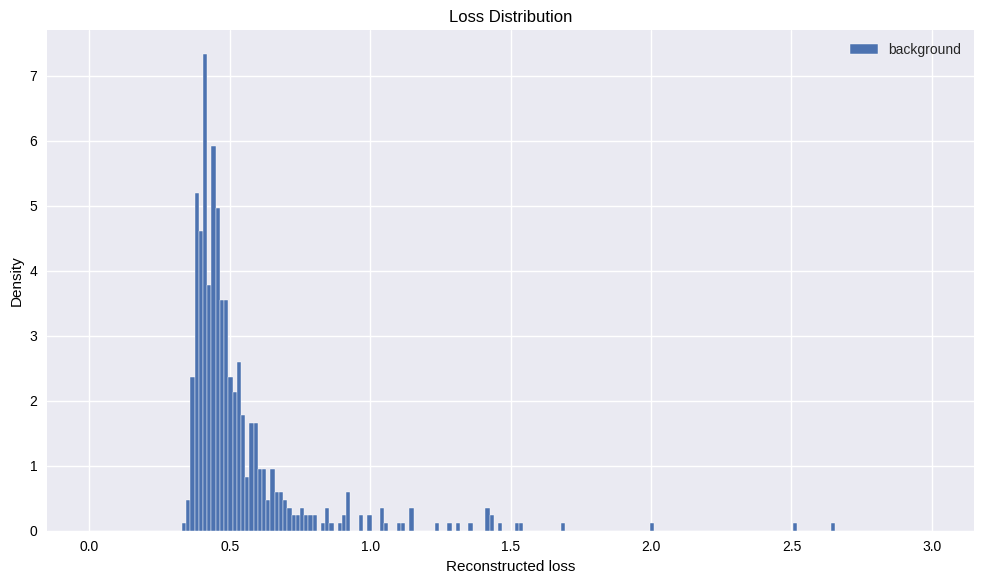

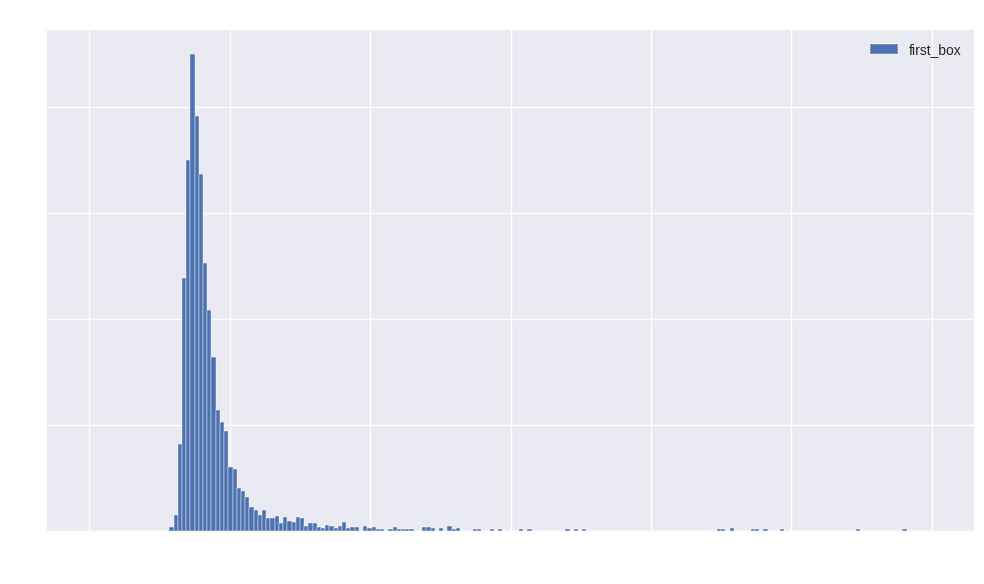

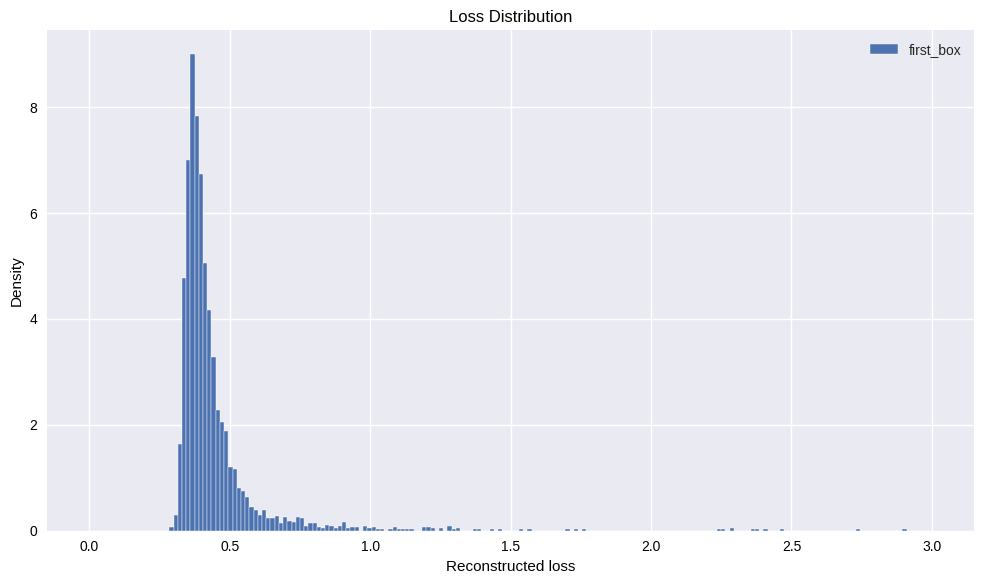

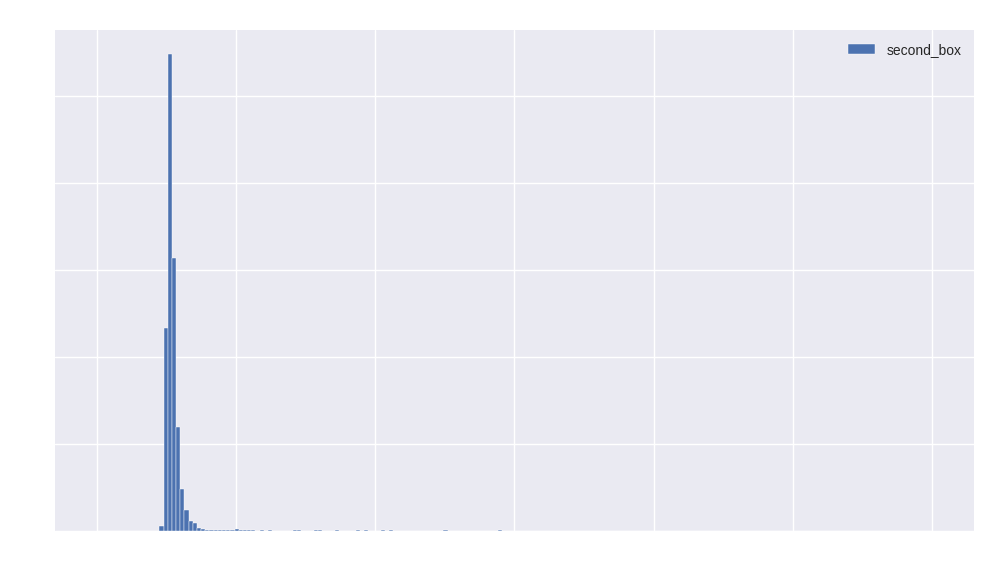

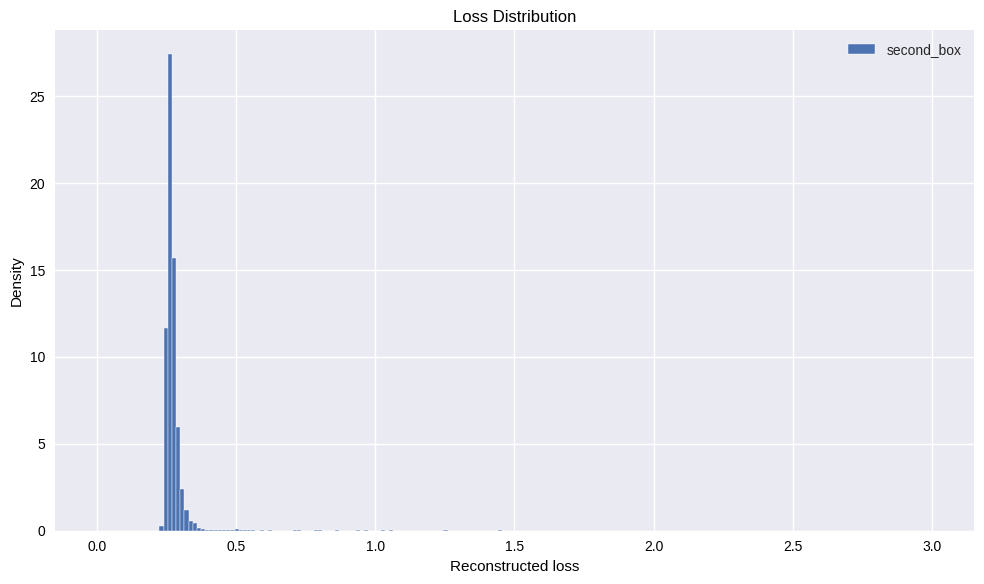

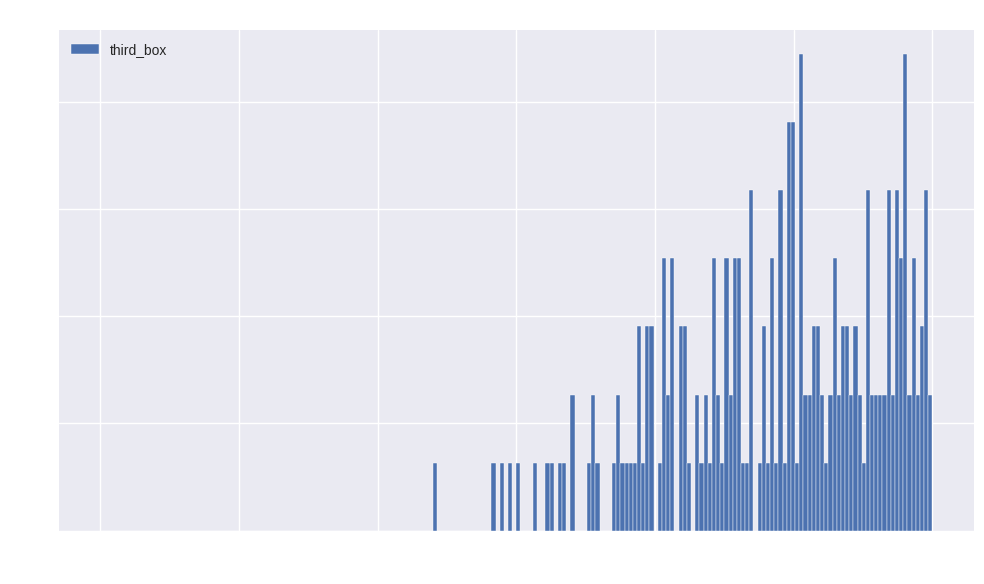

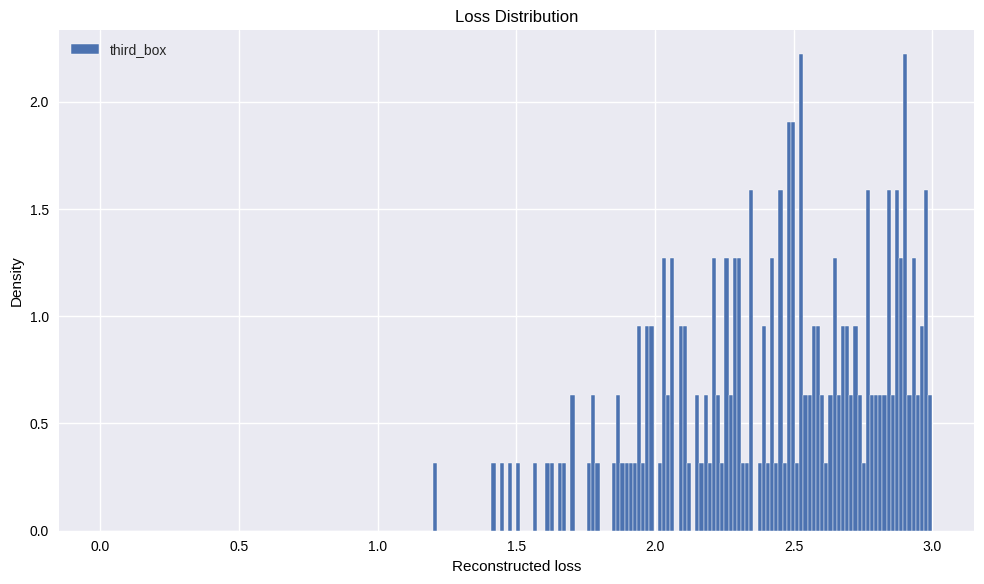

In [12]:
# Plot loss density (separately).
graph_text_face = [('white', 'none'), ('black', 'white')]
for key, value in loss.items():
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
        plt.hist(value, range=(0,3), bins=200, label=f'{key}', density=True)
        ax.set_title("Loss Distribution", color=text_color)
        ax.set_xlabel("Reconstructed loss", color=text_color)
        ax.set_ylabel("Density", color=text_color)
        plt.legend()
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout()
        # plt.savefig(f'{data_dir}/graphs/{key}_density_{face_color}.png', dpi=600, bbox_inches='tight')
        plt.show()

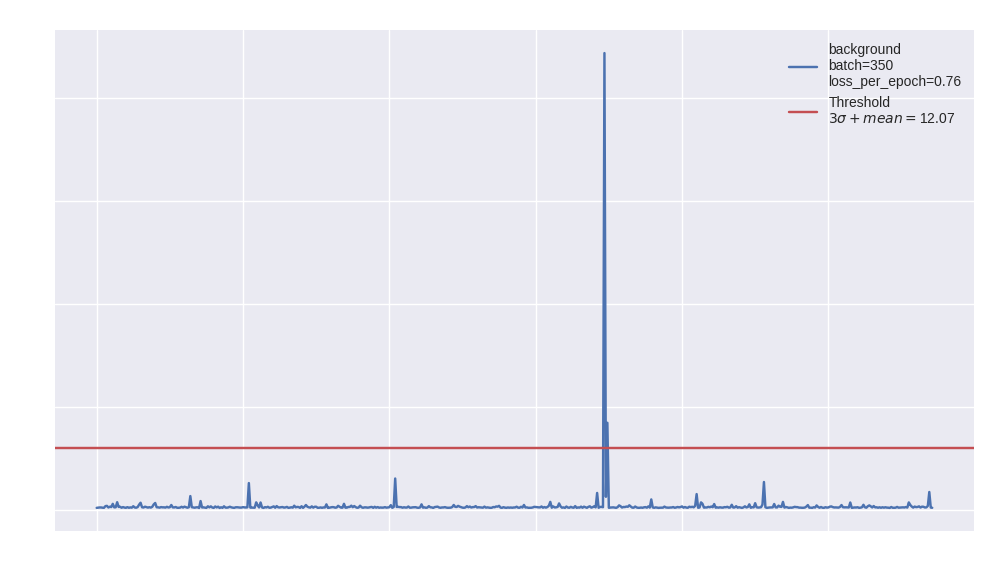

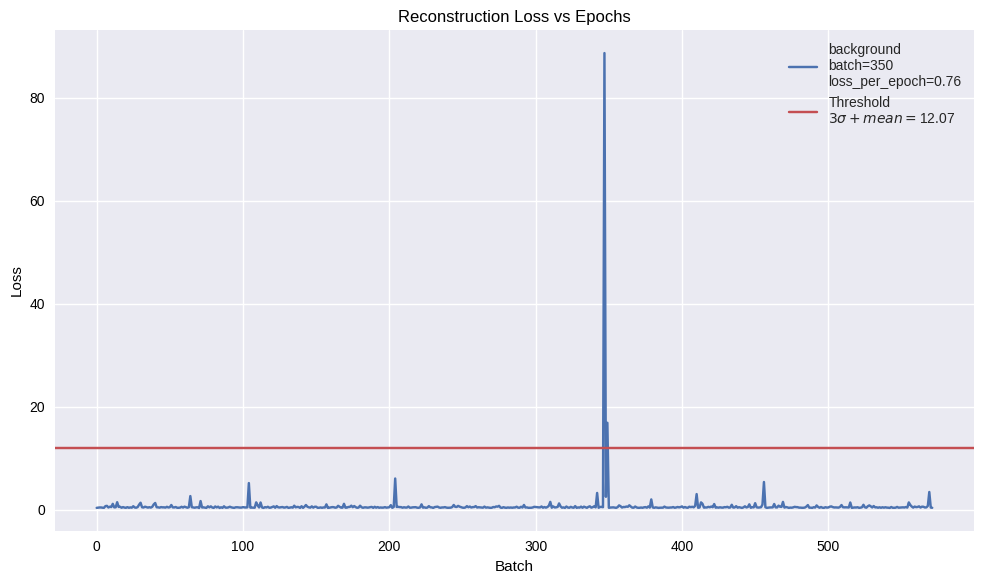

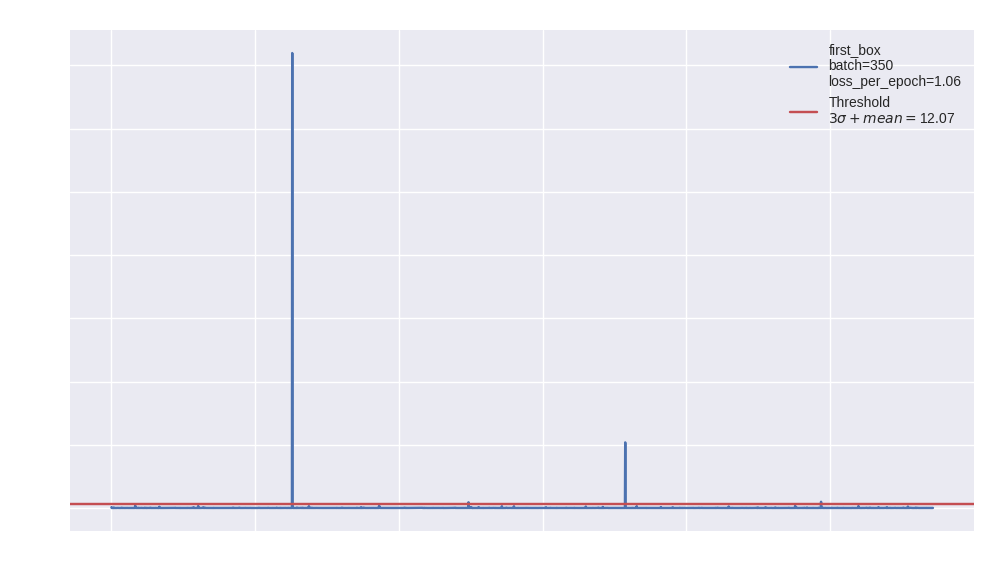

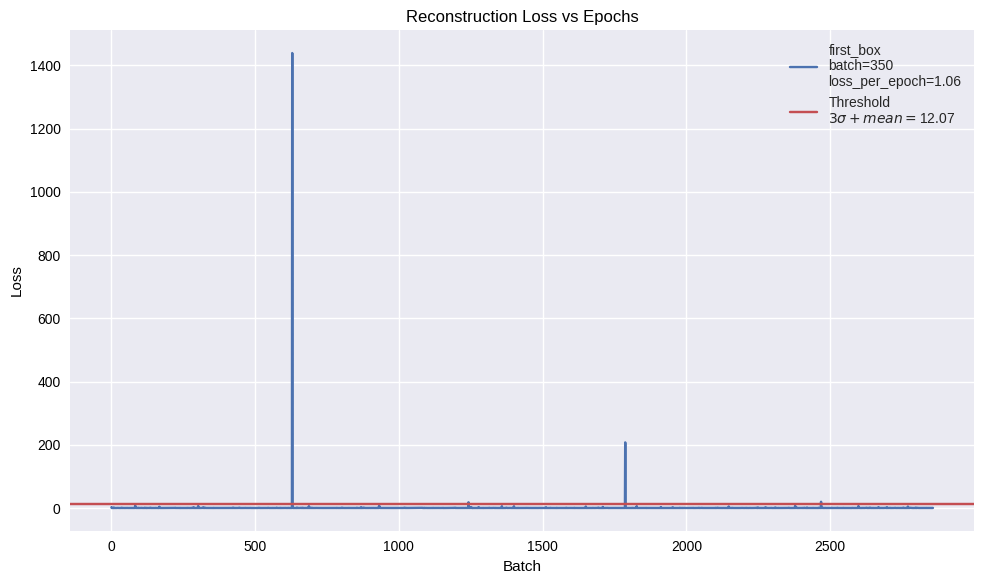

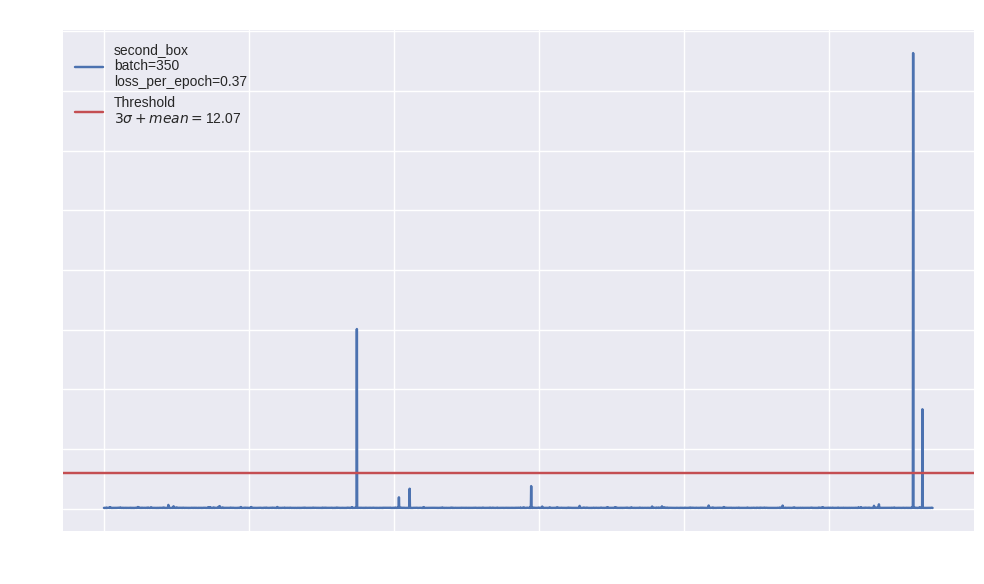

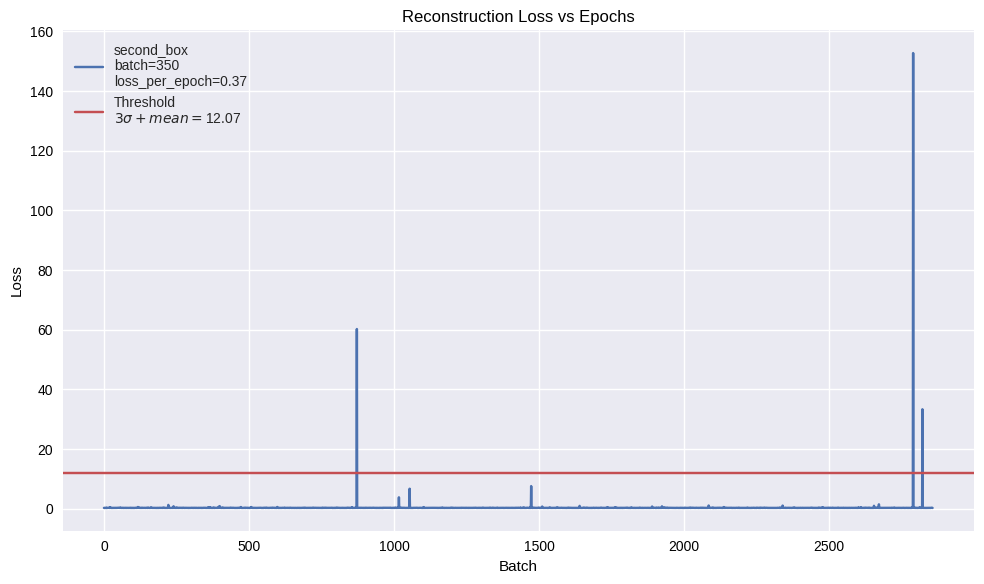

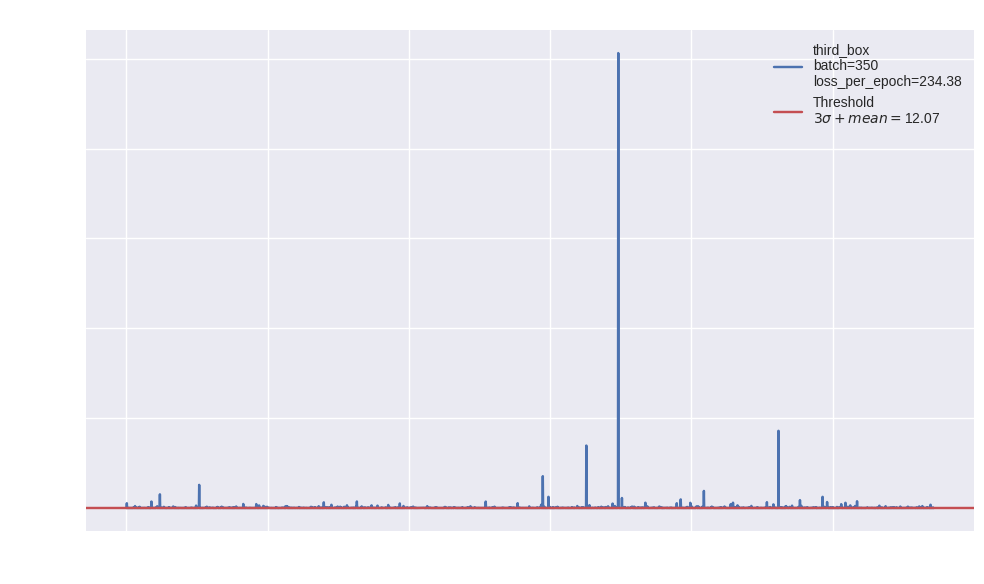

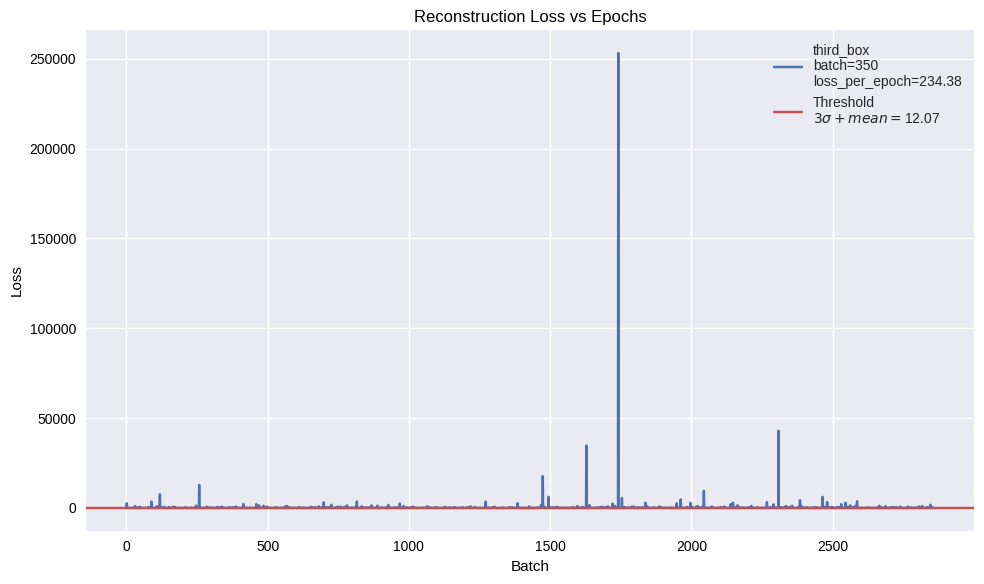

In [13]:
# Plot Batch vs Loss (separately).
for key, value in loss.items():
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(10, 6), facecolor=face_color)
        plt.plot(value, label=f'{key}\nbatch={batch_size}\nloss_per_epoch={value.mean():.2f}')
        plt.axhline(threshold, color=sns.color_palette()[2], label=f'Threshold\n$3\sigma+mean=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Epochs", color=text_color)
        plt.legend()
        ax.set_xlabel("Batch", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout()
        # plt.savefig(f'{data_dir}/graphs/{key}_loss_batch_{face_color}.png', dpi=600, bbox_inches='tight')
        plt.show()